# ASTR3110 Tutorial 5: Principal Component Analysis

Tutorial 5 of the *'Data Science Techniques in Astrophysics'* course at Macquarie University.

## Learning outcomes from this tutorial

 * Understand what is meant by dimensionality reduction.
 * Understand what principal axes are and how they relate to variance.
 * Use SciKit Learn to identify principal axes on a simple 2D dataset.
 * Understand how to select the axes containing most information.
 * Use PCA to show how an image-based dataset decomposes into clusters in 2D.
 * Use PCA to filter noise from images.

## Setup

This week, we won't need to access any data on disk, so simply start a new *Python 3* notebook on Google Colab. The tutorial content is based on a section of the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas (you can access this very handy book if you are on the MQ VPN, and by signing in with your MQ email). Additional content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

In [1]:
# Import necessary modules and set plots to appear inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

## Introduction to Principal Component Analysis

Principal Component Analysis (PCA) is a method of reducing the *dimensionality* of multi-dimensional data. We start by identifying the axes along which information is maximised (called the *principal axes*) and can then choose to collapse one or more of the smaller (i.e., least important) of these axes by projecting the data along this axis. We can illustrate this on an artificially generated 2D dataset.

In [2]:
#Notes: to demonstrate principal component analysis, it is best to start off with a 
#2-dimensional dataset that looks like a straight line plus some scatter. I.e., the y-values are correlated
#with the x-values. Last week we looked at fitting the data with a model to try to understand
#how we can predict the y-value given the x and the model parameters. Here, we will use PCA to try to learn
#the relationship between the x- and y-values by trying to determine the principal axis of the data, i.e., the
#projection of the data that contains the most information.

# Create a random sample of correlated 2D data 
nSamp = 200
nDim = 2
rng = np.random.RandomState(1)#setting RandomState to 1 means that we should all get the same answer.
#use the matrix dot product to generate a correlated 2D dataset.
data = np.dot(rng.rand(nDim, nDim),   # <- Note the use of randn and rand here.
              rng.randn(nDim, nSamp))
#In the above, demo rng.rand(nDim,nDim) is a 2x2 array. Dot 
#product with a nDim x nSamp array gives a 2x200 shape array. 
#Essentially this just gives us a correlated linear relation that has some scatter.

#Need to transpose to get a 200x2 array because functions that we will use later on will need
#the array to be in that order.
data=data.T

# Print the 1st 10 samples
print(data[0:10, :])
print(data.shape)
# Note that columns of data are addressed like:
#data[:, 0]  # <- 1st dimension of 200 samples

[[-0.62530162 -0.17006366]
 [ 0.96069503  0.5909006 ]
 [-0.59854339 -0.40259339]
 [-2.22805938 -0.53257674]
 [-0.46143006 -0.49886724]
 [-0.95892903 -0.26933102]
 [-0.67307991 -0.33830855]
 [ 1.30501861  0.59135785]
 [ 0.3745456  -0.0985442 ]
 [-1.82628627 -0.40617025]]
(200, 2)


In [3]:
rng.rand(nDim, nDim)

array([[0.57071585, 0.99675343],
       [0.81683511, 0.59437262]])

Now plot the data on a scatter plot to get a feel for it.

Text(0, 0.5, 'Y')

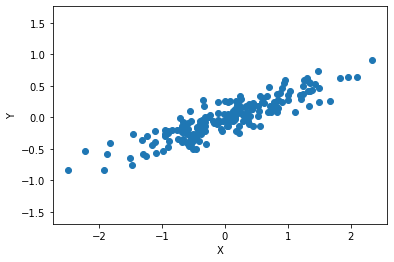

In [4]:
# Plot the data on a 2D scatter plot
plt.scatter(data[:, 0], data[:, 1])
plt.axis("equal")
plt.xlabel("X")
plt.ylabel("Y")
#Notes: can see that there is clearly a linear correlation. What PCA does, is quantify the scatter along each direction
#and identify the principal axis where the scatter is highest. E.g., in the below plot, if you look down the "long" 
#axis, that is where scatter is highest; that is where the majority of the information is. At 90 degrees to the 
#linear trend, the scatter is lower; that is the second most important component and is mostly just noise. So, PCA 
#can help us to identify which dimensions of the dataset are most important. This allows us to collapse the data in 
#the second most important dimension, and only keep the most important info. I.e., we reduce the dimensionality
#but keep the majority of the information.

#clearly this is a pretty simple case where you can read off the most important axis by eye, but the power with PCA 
#is that you can do this in multi-dimensional data where things are more complicated.

It is clear from this plot that the most significant principal axis is along the line of best correlation and the next most significant axes is at 90-degrees to that. We can determine the vectors of these axes by using the PCA implementation in *SciKit Learn*. 

In [5]:
from sklearn.decomposition import PCA

# Initialise a PCA fitter object -- similar to how the MCMC was run last week, you need to initialise
# the PCA fitter with some necessary parameters, in this case the number of components.
# You must specify the number of axes to solve for.
myPCA = PCA(n_components=2)

# Run the fitting method on the 2-D data array.
# Note: the data must be in order (nSamples, nDimensions)
myPCA.fit(data)

PCA(n_components=2)

Like the MCMC fitter we encountered last week, the results are stored inside the ```myPCA``` object. For a detailed explanation access the help by executing ```myPCA??```. The important variables are ```myPCA.mean_```, ```myPCA.components_``` and ```myPCA.explained_variance_```.

In [6]:
# Access documentation
myPCA?

In [7]:
# myPCA.components_ gives the direction of the 
# principal axes as unit vectors (length 1).
# These are the coordinates of the ends of the
# axes when plotted from the mean of the data.
print(myPCA.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [8]:
# myPCA gives the lengths of the principal axes in terms of variance
print(myPCA.explained_variance_)
#explain the above two things on the plot.

[0.7625315 0.0184779]


In [9]:
#Aside: can also look at how much of the dataset's variance is explained by each principal component:
print(myPCA.explained_variance_ratio_)
#As expected, the majority (~98%) of the dataset's variance is contained in the first principal axis.

[0.97634101 0.02365899]


Now plot the vectors over the data:

In [10]:
# First define a short function to plot an arrow
# I'll simply explain this code to avoid typing it out.
# Basically, it's a way to overlay arrows on a data plot.
def draw_vector(startCoord, endCoord, ax=None):
    """Function to draw a vector on a plot."""

    # By default, set the axis to the current one
    if ax is None:
        ax = plt.gca()#gca = get current axis. This sets the axis to the axis set by plt.scatter below.

    # Set the arrow properties as a dictionary
    arrowprops = dict(arrowstyle='->', linewidth=2, color='r')

    # Annotate the plot with a blank label and an arrow
    ax.annotate('', endCoord, startCoord, arrowprops=arrowprops)

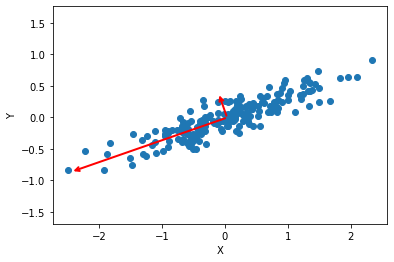

In [11]:
# Plot the data
plt.scatter(data[:, 0], data[:, 1])
plt.axis("equal")
plt.xlabel("X")
plt.ylabel("Y")

# Loop through the variances and axis vectors and plot an arrow for each principal component
for var, vector in zip(myPCA.explained_variance_, # zip is explained below. This essentially takes the variance and
                          myPCA.components_):     #positions of the PCA outputs and loops over them

    # Plot the 3-sigma length vector
    stdev3 = 3 * np.sqrt(var)#This should encompass 99% of the distribution for a Gaussian. I.e., should ~match the 
    v = vector * stdev3      #max length of the data.
    #print(myPCA.mean_,var,vector)
    draw_vector(myPCA.mean_, myPCA.mean_ + v)
    #myPCA.mean_ gives the mean position of the two PCA components.

In [12]:
#Notes: These vectors represent the principal axes of the data, and the length of the vector is an indication of how 
#"important" that axis is in describing the distribution of the data. More precisely, it is a measure of the variance 
#of the data when projected onto that axis. The projection of each data point onto the principal axes are the 
#"principal components" of the data.

#the key thing here is that PCA orders the components based on how much variance is explained, with the axis that
#contains the most information, or variance, ranked highest.

In [13]:
#zip explanation
a1 = list(range(5))#returns list of numbers 0-5
a2=list(range(6,11))#returns list of number 6-10
print(a1,a2)
list(zip(a1,a2))# vertically stacks 1D arrays into 2D by matching pairs in the separate 1D arrays, e.g, (0,6), (1,7) etc.

[0, 1, 2, 3, 4] [6, 7, 8, 9, 10]


[(0, 6), (1, 7), (2, 8), (3, 9), (4, 10)]

Note that your data and axis directions may be different to the above plot. SciKit Learn has a function to transform the data onto the orthogonal principal axes. Do the transformation and plot:

Text(0, 0, '')

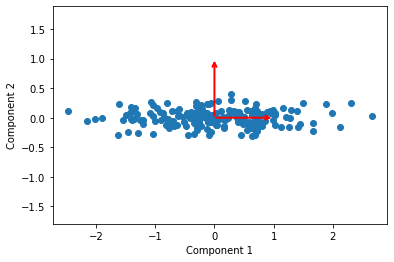

In [14]:
# Transform the data onto the PCA axes
dataPCA = myPCA.transform(data)

# Plot the transformed data
plt.scatter(dataPCA[:, 0], dataPCA[:, 1])
plt.axis("equal")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
 
# Draw the axes manually
arrowprops = dict(arrowstyle='->', linewidth=2, color='r')
plt.annotate('', [0, 1], [0, 0], arrowprops=arrowprops)
plt.annotate('', [1, 0], [0, 0], arrowprops=arrowprops)

This transformation from data axes to principal axes is an *affine transformation*, which basically means it is composed of a translation, rotation, and uniform scaling.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Try using PCA for dimensionality reduction by collapsing the least-useful axis.

In [15]:
# Make a new PCA object with only one dimension
myPCA = PCA(n_components=1)#,whiten=True)

# Run the fitter
myPCA.fit(data)

# Transform the data into PCA space
dataPCA = myPCA.transform(data)
print("Original shape:   ", data.shape)
print("Transformed shape:", dataPCA.shape)


Original shape:    (200, 2)
Transformed shape: (200, 1)


We can transform this data back to understand what the effect of reducing it to a single dimension has been:

Text(0, 0.5, 'Y')

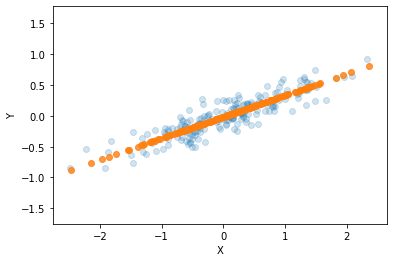

In [16]:
# Transform the data back
dataNew = myPCA.inverse_transform(dataPCA)#NB: feeding it the 1D transformed dataspace and creating a 2D one!

# Plot the data -- copy the plotting code from above and change second to data new.
plt.scatter(data[:, 0], data[:, 1], alpha=0.2)
plt.scatter(dataNew[:, 0], dataNew[:, 1], alpha=0.8)
plt.axis("equal")
plt.xlabel("X")
plt.ylabel("Y")


You can see that the information along the least-important axis has been removed. The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

In [20]:
#the above example is a relatively easy way to visualise the problem to understand what PCA is doing. We can see
#by eye that there is a trend and pretty well identify the principal axis in our head.
#The method becomes much more powerful when there are multiple dimensions at play, and visualising and ordering the 
#axis by importance based on the information they hold is far more difficult.

#one way that PCA can be very useful is in visualising the data. You can reduce the number of dimensions substantially
#and look for patterns in the reduced-dimensionality of the data that may, e.g., allow for more easy classification 
#of the data into separate objects.

#Below we take a look at a more complicated problem that is often used for testing machine learning and other 
#algorithms on. It's a sample of hand-written numerical digits that is contained within the scikit learn datasets.


## PCA for Visualisation

Here we use a simple set of images as a toy example: small images of hand-written digits from the MNIST dataset (a very commonly used image dataset in the machine-learning world and the simplest 'hello world' example for many ML algorithms; MNIST = Modified National Institute of Standards and Technology database). 

SciKit Learn has access to this dataset built-in:

In [21]:
# Load the digits dataset
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

There are 1797 elements in the dataset, each of length 64.These are 8x8 pixel images that have been flattened.

In [22]:
# Access a single member of the dataset
digits.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

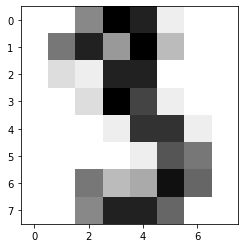

In [23]:
# Reshape the 1D array back to a 2D (8x8) image and plot
arr = digits.data[3].reshape((8, 8))
plt.imshow(arr, cmap="gray_r")

In [24]:
#there is also a corresponding 1797-length vector that gives the correct label for each of these numbers, 
#i.e., it tells you what the sometimes messy handwritten number is. This is very handy for training purposes
#for machine learning and other algorithms. We'll use this a bit later.
digits.target[3]

3

The data consists of 8×8 pixel images, meaning that they are 64-dimensional. To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [25]:
# Project from 64 to 2 dimensions
myPCA = PCA(n_components=2)

# the .fit_transform() method fits the required number
# of components and returns the reprojected data in 1 step
#before we ran .fit(), then .transform(), this does it one fell swoop!
projected = myPCA.fit_transform(digits.data) #projected is each 1797 handwritten digits 
                                             #projected onto the first 2 principal components.

# Feedback to user
print("Old data shape:", digits.data.shape)
print("New data shape:", projected.shape)

Old data shape: (1797, 64)
New data shape: (1797, 2)


We can now plot the first two principal components of each point to learn about the data:

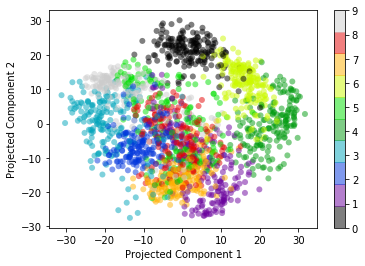

In [26]:
# We can colorise the data using the ground-truth labels
# that are also encoded in digits.target

plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target,        # <- colour by ground truth label
            edgecolor='none', 
            alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))#jet is quantised to have 10 colours. One for each of our labels 0-9

# Add labels
plt.xlabel('Projected Component 1')
plt.ylabel('Projected Component 2')
plt.colorbar()

(-35, 35)

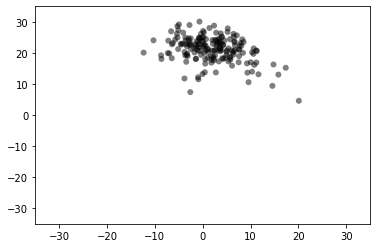

In [28]:
#plotting a single target digit, we can see that in PCA-space they 
#often occupy relatively distinct regions.
target=0
plt.scatter(projected[digits.target == target, 0], projected[digits.target == target, 1],
            edgecolor='none', 
            alpha=0.5,
            fc='k')
plt.xlim(-35,35)
plt.ylim(-35,35)

In [29]:
#this is just to show that each digit contains around 180 8x8 images.
projected[digits.target == target, 1].shape

(178,)

You can see here that images containing the same hand-written digits cluster in different regions of the projected 2D space. The full data for each digit is a 64-dimensional point cloud, and the points in the plot are the projection of each data point along the 2 directions with the largest variance. Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner.

You can imagine this being useful in a real world situation where you don't have the "labels". You can use PCA to to identify types of objects that lie in semi-distinct parts of a multi-dimensional PCA space (where the number of PCA dimensions is reduced compared with the entire original dataset). This is very useful for object classification.

### What do the components mean?

The PCA components can be thought of as *basis functions* - building blocks, the cumulative combination of which make up the whole picture. PCA gives the ability to order these in importance and select only the ones containing information on the *signal* in the data. See [here](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb) for a more full explanation.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative *explained variance ratio* as a function of the number of components. This is the ratio of the variance explained by the currently accepted components to the total variance.

Text(0, 0.5, 'cumulative explained variance')

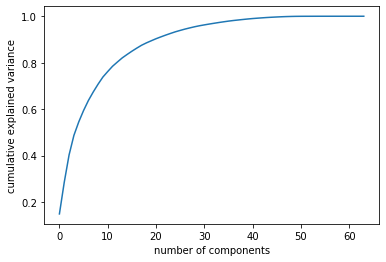

In [30]:
# Find the PCA components and do not restrict the
# number of components found (fully describe the data)
myPCA = PCA(n_components=None)#setting n_components to "none" is equivalent to setting to 64, i.e., the number of components in the data.
myPCA.fit(digits.data)

# Plot the cumulative sum of the explained_variance_ratio
plt.plot(np.cumsum(myPCA.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

A good selection here might be choosing to fit 20 components to retain 90% of the information. Note that that last 10% may be dominated by noise.

## PCA as Noise Filtering

PCA can also be used as a filtering approach for noisy data.
The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.
So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

Let's see how this looks with the digits data. First we will plot several of the input noise-free data:

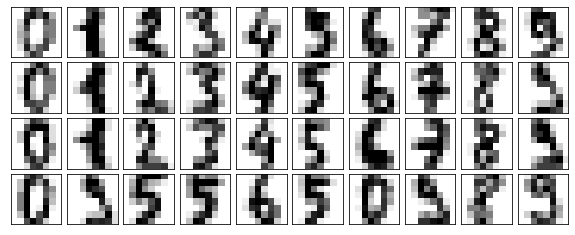

In [31]:
# Define a function to plot the images
def plot_digits(data, nRows=4):
    """Plot rows of images from the MNIST digits dataset."""
    
    
    # Setup the figure
    fig = plt.figure(figsize=(10, nRows))
    axes = fig.subplots(nRows, 10, 
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
    # Loop through the axes, plotting the images
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='gray_r', interpolation='nearest',
                  clim=(0, 16))

# Call the plotting function to plot the 1st 4 rows
plot_digits(digits.data, 4)

Now we can add some noise to the data:

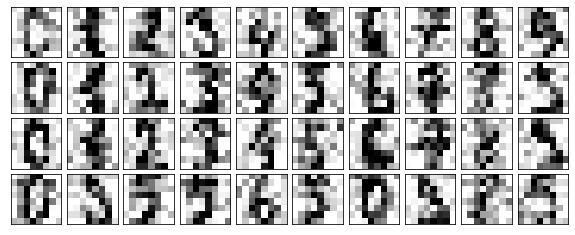

In [32]:
# Now add some random noise
np.random.seed(42)
dataNoisy = np.random.normal(digits.data,4)

# Plot the noisy data
plot_digits(dataNoisy,4)

A human observer can still make out which digits are in the images. Now see how PCA can identify the axes with information content and then filter on these to remove noise.

In [33]:
# By specifying a fraction for n_components, 
# we can ask the fitter to retain only components 
# containing 50% of the variance
myPCA = PCA(n_components=0.5).fit(dataNoisy)

# Print the number of components identified.
myPCA.n_components_

12

Here 50% of the variance amounts to 12 principal components.
Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

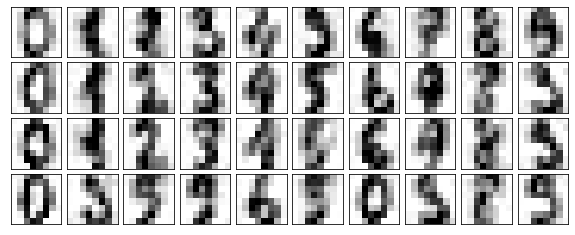

In [34]:
# Transform data into PCA space with 12 axes
dataPCA = myPCA.transform(dataNoisy)

# Transform back to the data space
dataFiltered = myPCA.inverse_transform(dataPCA)

# Plot the reconstructed data
plot_digits(dataFiltered)

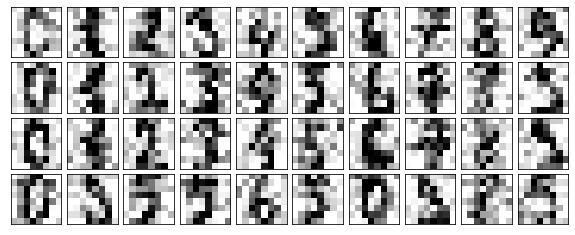

In [35]:
plot_digits(dataNoisy)

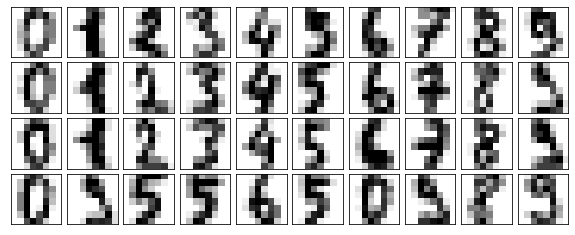

In [36]:
plot_digits(digits.data,4)